<a href="https://colab.research.google.com/github/Telemaco019/flower_recognition/blob/master/notebooks/tf_flowers_complete_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: try to use the ImageGenerator class provided by keras

#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [1]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
#!pip install kaggle
#!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

MessageError: ignored

In [0]:
!rm -rf ~/.kaggle/ 

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/flowers-recognition.zip

Archive:  /content/flowers-recognition.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace flowers/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Constants and imports


In [7]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import os 

import pandas as pd
import seaborn

Using TensorFlow backend.


In [8]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'
TULIP_DIR = 'tulip'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR, TULIP_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42

2.1.0-rc1


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [12]:
(X,Y) = load_dataset()

  2%|▏         | 12/769 [00:00<00:06, 113.99it/s]

Loading data from: /content/flowers/daisy/


  2%|▏         | 22/1055 [00:00<00:04, 212.66it/s]

Loading data from: /content/flowers/dandelion/


  3%|▎         | 25/784 [00:00<00:03, 245.58it/s]

Loading data from: /content/flowers/rose/


  3%|▎         | 20/734 [00:00<00:03, 198.97it/s]

Loading data from: /content/flowers/sunflower/


  2%|▏         | 23/984 [00:00<00:04, 221.77it/s]

Loading data from: /content/flowers/tulip/


100%|██████████| 984/984 [00:03<00:00, 294.36it/s]


In [13]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 4323
Total number of labels: 4323


**Split train, valid and test datasets**

In [14]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 3242
Validation dataset size: 810
Test dataset size: 271


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.figure() 
  plt.figure(figsize = (10,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.figure()
  plt.figure(figsize = (10,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plot_accuracy_curves(history)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_generator, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_generator, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
  STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(train_generator.n, STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(valid_generator.n, STEP_SIZE_TRAIN))

  history = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  Y_pred_prob = model.predict(test_generator, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  plt.figure(figsize = (10,7))
  cm = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
  cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)
  seaborn.heatmap(cm_df, annot=True)

  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

# Keras preprocessing


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True,)
train_generator = train_datagen.flow(x=X_train,
                                     y=Y_train, 
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     seed=SEED)

valid_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True,)
valid_generator = valid_datagen.flow(x=X_valid,
                                     y=Y_valid,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True,)
test_generator = test_datagen.flow(x=X_test,
                                   y=Y_test,
                                   batch_size=1,
                                   shuffle=False)

# Show some dataset image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


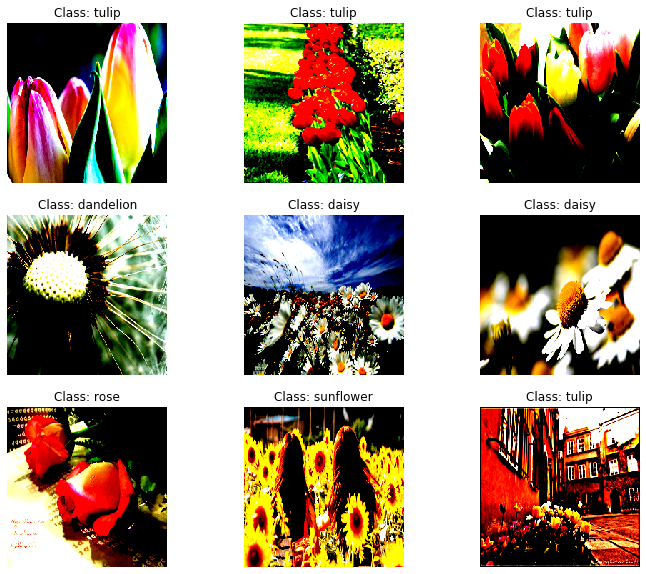

In [25]:
a,b = next(train_generator)
show_batch(a,b)

# Custom Keras CNN



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [27]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [28]:
epochs = 15
callbacks = get_early_stopping_callbacks(3, 'tf_flowers_base.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 101 steps, validate for 25 steps
Epoch 1/15
101/101 [==============================] - 15s 147ms/step - loss: 1.3092 - accuracy: 0.4293 - val_loss: 1.1214 - val_accuracy: 0.5350
Epoch 2/15
101/101 [==============================] - 7s 65ms/step - loss: 1.1042 - accuracy: 0.5411 - val_loss: 1.0159 - val_accuracy: 0.5850
Epoch 3/15
101/101 [==============================] - 6s 64ms/step - loss: 1.0155 - accuracy: 0.5950 - val_loss: 0.8835 - val_accuracy: 0.6513
Epoch 4/15
101/101 [==============================] - 7s 65ms/step - loss: 0.8552 - accuracy: 0.6798 - val_loss: 0.8531 - val_accuracy: 0.6825
Epoch 5/15
101/101 [==============================] - 6s 64ms/step - loss: 0.7556 - accuracy: 0.7153 - val_loss: 0.8508 - val_accuracy: 0.6913
Epoch 6/15
101/101 [==============================] 

<Figure size 432x288 with 0 Axes>

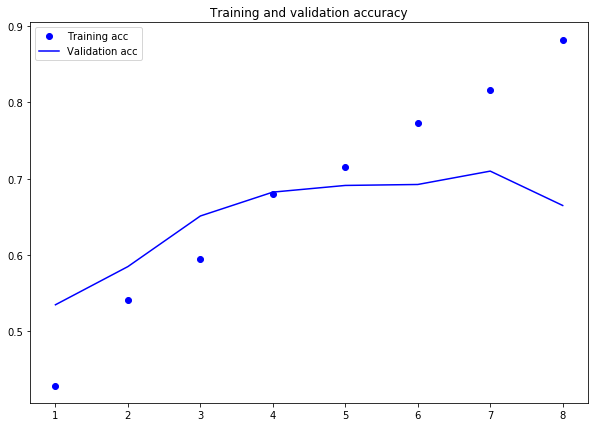

<Figure size 432x288 with 0 Axes>

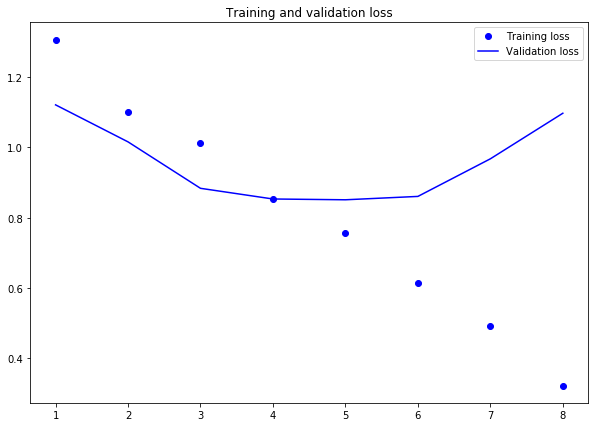

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.70|0.70|0.70
|Macro|0.73|0.69|0.70


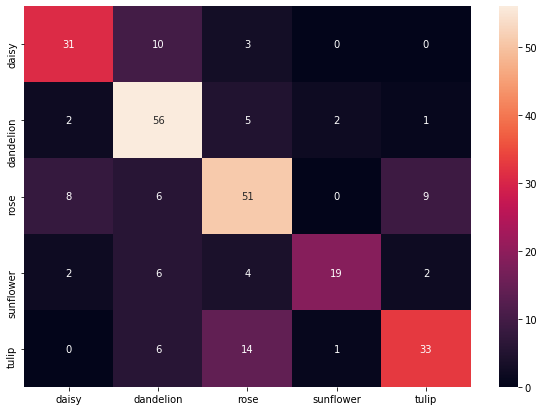

In [29]:
model = tf.keras.models.load_model('tf_flowers_base.h5')
plot_curves(history)
show_scores(model)

# Data augmentation and dropout
## Problem: Keras does not has random cropping support (while tensorflow data API has)


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   samplewise_std_normalization=True,
                                   samplewise_center=True,
                                   brightness_range=[0.8, 1.2])
train_generator = train_datagen.flow(x=X_train,
                                     y=Y_train, 
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     seed=SEED)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


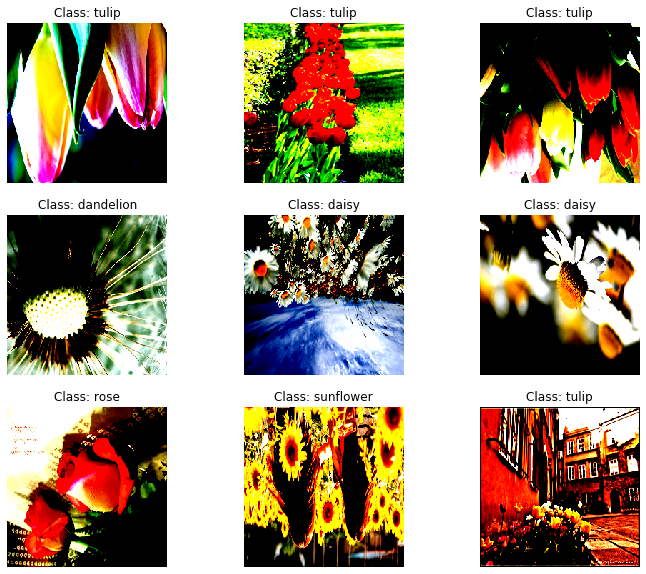

In [31]:
a, b = next(train_generator)
show_batch(a,b)

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [33]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

In [34]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 101 steps, validate for 25 steps
Epoch 1/30
101/101 [==============================] - 12s 121ms/step - loss: 1.2850 - accuracy: 0.4262 - val_loss: 1.1735 - val_accuracy: 0.5000
Epoch 2/30
101/101 [==============================] - 12s 117ms/step - loss: 1.1031 - accuracy: 0.5324 - val_loss: 1.1000 - val_accuracy: 0.5238
Epoch 3/30
101/101 [==============================] - 11s 113ms/step - loss: 1.0558 - accuracy: 0.5847 - val_loss: 0.9933 - val_accuracy: 0.5725
Epoch 4/30
101/101 [==============================] - 11s 113ms/step - loss: 0.9723 - accuracy: 0.6184 - val_loss: 0.8802 - val_accuracy: 0.6463
Epoch 5/30
101/101 [==============================] - 11s 113ms/step - loss: 0.8944 - accuracy: 0.6542 - val_loss: 0.9192 - val_accuracy: 0.6313
Epoch 6/30
101/101 [========================

<Figure size 432x288 with 0 Axes>

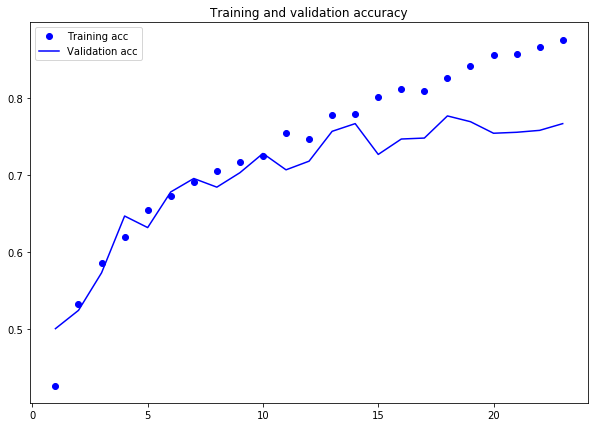

<Figure size 432x288 with 0 Axes>

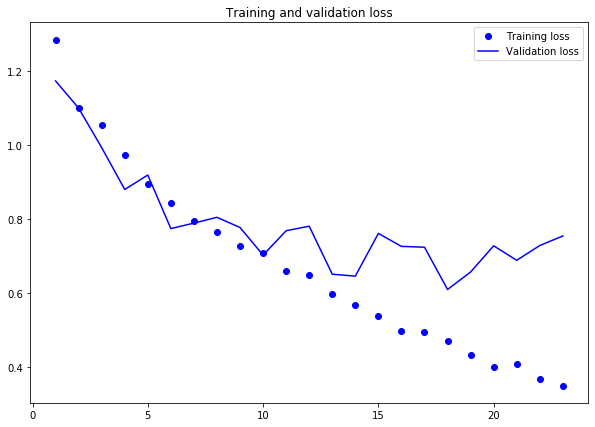

|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.76|0.76|0.76
|Macro|0.77|0.77|0.77


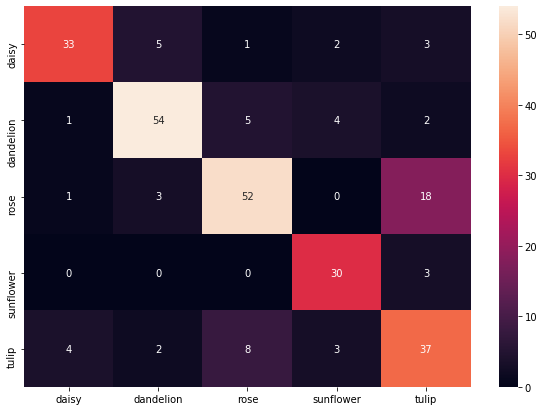

In [35]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 206 out of 271


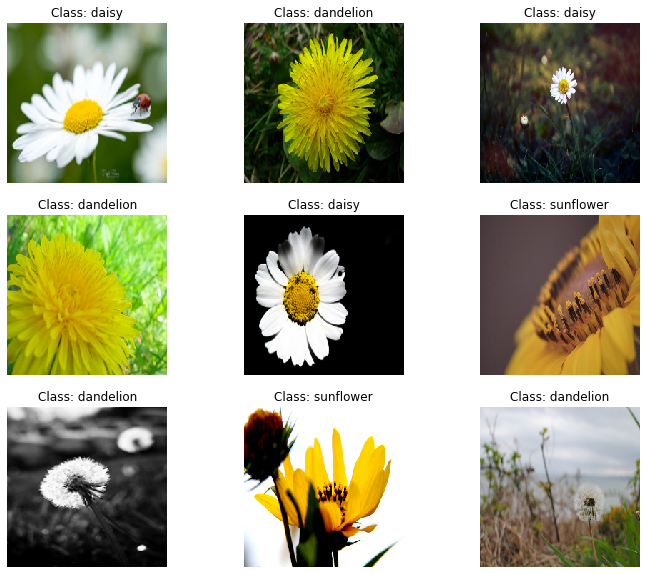

In [36]:
plot_correct_predictions(model)

Wrong predictions: 65 out of 271


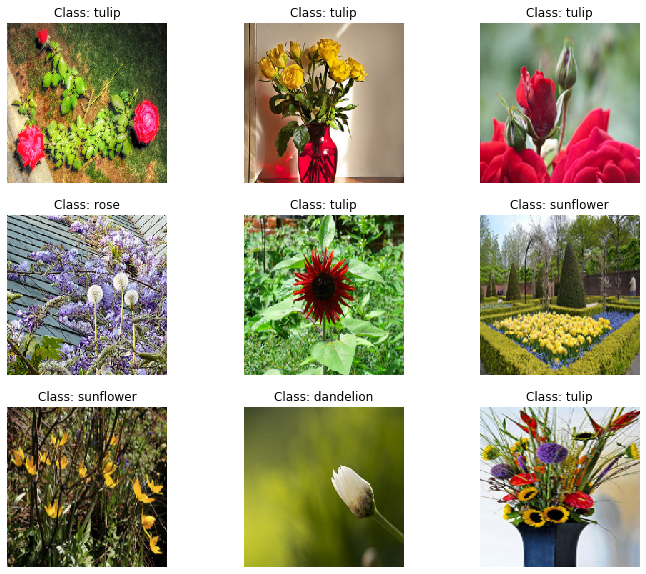

In [37]:
plot_wrong_predictions(model)